# ours Î®ºÏ†Ä ÎèåÎ¶¨Í∏∞

In [ ]:
import json
import os
import time
import win32com.client
import pythoncom
import jsonlines
from pathlib import Path
from main_original import main  # main Ìï®Ïàò import

def load_instructions(json_path):
    """instruction JSON ÌååÏùºÏùÑ Î°úÎìúÌï©ÎãàÎã§."""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"JSON ÌååÏùº Î°úÎìú Ïò§Î•ò: {e}")
        return {}

def get_slide_number(instruction_key):
    """instruction keyÏóêÏÑú Ïä¨ÎùºÏù¥Îìú Î≤àÌò∏Î•º Ï∂îÏ∂úÌï©ÎãàÎã§."""
    if '-' in instruction_key:
        return instruction_key.split('-')[0]
    return instruction_key

def write_log(log_file, log_data):
    """Î°úÍ∑∏ ÌååÏùºÏóê ÏïàÏ†ÑÌïòÍ≤å Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î°ùÌï©ÎãàÎã§."""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            with jsonlines.open(log_file, mode='a') as writer:
                writer.write(log_data)
            return True
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Î°úÍ∑∏ ÏûëÏÑ± Ïò§Î•ò, Ïû¨ÏãúÎèÑ Ï§ë ({attempt+1}/{max_retries}): {e}")
                time.sleep(0.5)
            else:
                print(f"Î°úÍ∑∏ ÏûëÏÑ± ÏµúÏ¢Ö Ïã§Ìå®: {e}")
                return False

def process_instruction(instruction_key, instruction_text, result_folder, log_file):
    """
    Ï£ºÏñ¥ÏßÑ instructionÏùÑ Ï≤òÎ¶¨ÌïòÍ≥† Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï©ÎãàÎã§.
    1. PPT Ïó¥Í≥† main() Ï†ÅÏö©
    2. SaveAs, Ïã§Ìå® Ïãú SaveCopyAs ‚Üí ÏõêÏúÑÏπò Ïù¥Îèô
    3. ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖò Ï¶âÏãú Close
    4. PowerPoint Ïï†ÌîåÎ¶¨ÏºÄÏù¥ÏÖò Quit
    5. Î°úÍ∑∏ Í∏∞Î°ù
    """
    slide_num = get_slide_number(instruction_key)
    slide_path = os.path.abspath(f"evaluation/benchmark_ppts/slide_{slide_num}.pptx")
    result_path = os.path.join(result_folder, f"result_slide_{slide_num}_instruction_{instruction_key}.pptx")

    pythoncom.CoInitialize()
    ppt_app = None
    presentation = None
    start_time = time.time()
    status = "error"
    error_message = None
    result = None

    try:
        # PowerPoint Ïó∞Í≤∞ ÎòêÎäî Ïã§Ìñâ
        try:
            ppt_app = win32com.client.GetActiveObject("PowerPoint.Application")
        except:
            ppt_app = win32com.client.Dispatch("PowerPoint.Application")
        if ppt_app is None:
            raise RuntimeError("PowerPoint Ïï†ÌîåÎ¶¨ÏºÄÏù¥ÏÖòÏùÑ ÏãúÏûëÌï† Ïàò ÏóÜÏäµÎãàÎã§.")

        ppt_app.Visible = True
        
        # ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖòÏùÑ ÌôïÏã§Ìûà Ïó¥Í≥† Ï§ÄÎπÑÎêòÏóàÎäîÏßÄ ÌôïÏù∏
        presentation = ppt_app.Presentations.Open(slide_path)
        if presentation is None:
            raise RuntimeError(f"ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖòÏùÑ Ïó¥ Ïàò ÏóÜÏäµÎãàÎã§: {slide_path}")
        
        # PowerPointÍ∞Ä ÏôÑÏ†ÑÌûà Î°úÎìúÎê† ÏãúÍ∞ÑÏùÑ Ï†úÍ≥µ
        time.sleep(0.5)
        
        # Ïù∏Ïä§Ìä∏Îü≠ÏÖò Ìè¨Îß∑ÌåÖ
        if "{slide_num}" in instruction_text:
            formatted_instruction = instruction_text.replace("{slide_num}", "1")
        else:
            formatted_instruction = instruction_text
        
        # main Ìï®Ïàò Ïã§Ìñâ - PowerPointÍ∞Ä ÌôïÏã§Ìûà Ï§ÄÎπÑÎêú ÌõÑÏóê Ïã§Ìñâ
        try:
            # Î®ºÏ†Ä presentationÏù¥ activeÌïúÏßÄ ÌôïÏù∏
            ppt_app.ActivePresentation  # Ïù¥ Ìò∏Ï∂úÎ°ú PowerPointÍ∞Ä ÌôúÏÑ±ÌôîÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
            result = main(formatted_instruction, rule_base_apply=False)
        except Exception as main_err:
            error_message = f"main() Ìï®Ïàò Ïã§Ìñâ Ïò§Î•ò: {main_err}"
            raise RuntimeError(error_message)

        # ÎîîÎ†âÌÜ†Î¶¨ Î∞è ÌååÏùº Ï§ÄÎπÑ
        os.makedirs(os.path.dirname(result_path), exist_ok=True)
        if os.path.exists(result_path):
            try:
                os.remove(result_path)
            except:
                # Ïû†Í∏à Î¨∏Ï†ú Ïãú Ïù¥Î¶Ñ Î≥ÄÍ≤Ω
                result_path = os.path.join(
                    result_folder,
                    f"result_slide_{slide_num}_instruction_{instruction_key}_{int(time.time())}.pptx"
                )

        absolute_result_path = os.path.abspath(result_path)
        save_success = False

        # 1Ï∞®: SaveAs
        try:
            presentation.SaveAs(FileName=absolute_result_path)
            save_success = True
        except Exception as save_err:
            # 2Ï∞®: SaveCopyAs + Ïù¥Îèô
            try:
                temp_name = f"temp_{int(time.time())}_{os.path.basename(result_path)}"
                temp_path = os.path.join(os.path.dirname(absolute_result_path), temp_name)
                presentation.SaveCopyAs(FileName=temp_path)
                # Î∞îÎ°ú ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖò Îã´Í∏∞
                presentation.Close()
                presentation = None
                time.sleep(0.5)
                if os.path.exists(temp_path):
                    if os.path.exists(absolute_result_path):
                        os.remove(absolute_result_path)
                    os.rename(temp_path, absolute_result_path)
                    save_success = True
            except Exception as alt_err:
                error_message = f"SaveAs Ïã§Ìå®: {save_err}; SaveCopyAs Ïã§Ìå®: {alt_err}"

        # Ï†ÄÏû• ÌõÑ Ï¶âÏãú Îã´Í∏∞
        if save_success:
            status = "success"
            # presentationÏù¥ ÎÇ®ÏïÑÏûàÎã§Î©¥ Îã´Í∏∞
            if presentation:
                presentation.Close()
                presentation = None

    except Exception as e:
        error_message = str(e)
        print(f"Ïò§Î•ò Î∞úÏÉù: {instruction_key} ‚Äì {e}")

    finally:
        # Ïï†ÌîåÎ¶¨ÏºÄÏù¥ÏÖò Ï¢ÖÎ£å
        try:
            if ppt_app:
                ppt_app.Quit()
        except Exception as quit_err:
            print(f"PowerPoint Quit Ïò§Î•ò: {quit_err}")

        # Î°úÍ∑∏ Í∏∞Î°ù
        end_time = time.time()
        log_data = {
            "instruction_key": instruction_key,
            "slide_num": slide_num,
            "instruction": instruction_text #.replace("{slide_num}", str(int(slide_num) + 1))
            ,
            "execution_time": end_time - start_time,
            "status": status
        }
        if status == "success":
            log_data["result"] = result
        if error_message:
            log_data["error_message"] = error_message
        write_log(log_file, log_data)

        try:
            pythoncom.CoUninitialize()
        except:
            pass

def main_experiment():
    total_start = time.time()
    instruction_path = "expanded_instruction_379.json"
    result_folder = "result_gpt4-1"
    log_file = os.path.join(result_folder, "experiment_log.jsonl")
    os.makedirs(result_folder, exist_ok=True)

    # Í∏∞Ï°¥ Î°úÍ∑∏ ÌååÏùºÏóêÏÑú Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction_key Î°úÎìú
    processed_keys = set()
    if os.path.exists(log_file):
        try:
            with jsonlines.open(log_file, mode='r') as reader:
                for log_entry in reader:
                    # instruction_keyÍ∞Ä ÏûàÎäî Ìï≠Î™©Îßå Ï∂îÍ∞Ä (ÏöîÏïΩ Ìï≠Î™© Ï†úÏô∏)
                    if 'instruction_key' in log_entry:
                        processed_keys.add(log_entry['instruction_key'])
            print(f"Î°úÍ∑∏ ÌååÏùºÏóêÏÑú {len(processed_keys)}Í∞úÏùò Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instructionÏùÑ Î∞úÍ≤¨ÌñàÏäµÎãàÎã§.")
        except Exception as e:
            print(f"Í∏∞Ï°¥ Î°úÍ∑∏ ÌååÏùº ÏùΩÍ∏∞ Ïò§Î•ò: {e}")
            # Ïò§Î•ò Î∞úÏÉù Ïãú Îπà ÏÑ∏Ìä∏Î°ú Í≥ÑÏÜç ÏßÑÌñâ
            pass

    instructions = load_instructions(instruction_path)
    if not instructions:
        print("Ïù∏Ïä§Ìä∏Îü≠ÏÖò Î°úÎìú Ïã§Ìå®, Ï¢ÖÎ£åÌï©ÎãàÎã§.")
        return

    processed = 0
    skipped = 0
    for key, text in instructions.items():
        # Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞
        if key in processed_keys:
            print(f"Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: {key}")
            skipped += 1
            continue
            
        if "{{slide_number}}" in text:
            text = text.replace("{{slide_number}}", "1")
        process_instruction(key, text, result_folder, log_file)
        processed += 1
        time.sleep(1)

    total_end = time.time()
    summary = {
        "total_processed": processed,
        "total_skipped": skipped,
        "total_time": total_end - total_start,
        "avg_time": (total_end - total_start) / processed if processed else 0,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    write_log(log_file, summary)
    print("Ïã§Ìóò ÏôÑÎ£å:", summary)

if __name__ == "__main__":
    main_experiment()

c:\Users\wjdrb\anaconda3\envs\pptagent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Î°úÍ∑∏ ÌååÏùºÏóêÏÑú 71Í∞úÏùò Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instructionÏùÑ Î∞úÍ≤¨ÌñàÏäµÎãàÎã§.
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 0
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 1
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 2
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 3
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 4
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 5
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 6
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 7
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 8
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 9
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 10
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 11
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 12
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 13
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 14
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 15
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 16
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 17
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 18
Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú instruction Í±¥ÎÑàÎõ∞Í∏∞: 19
Ïù¥ÎØ∏ Ï≤

2025-05-14 01:32:56.871 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:33:42.470 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:34:26.331 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:35:10.062 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:35:56.925 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:36:33.739 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:37:12.422 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:38:15.173 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************M5D0
2025-05-14 01:39:58.288 

In [1]:
# ÏÖÄ 1: ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
import json
import pandas as pd
import numpy as np
from IPython.display import display


In [2]:
# ÏÖÄ 2: JSONL ÌååÏùº Î°úÎìú Ìï®Ïàò Ï†ïÏùò Î∞è Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
def load_jsonl(filepath):
    """JSONL ÌååÏùºÏùÑ ÏùΩÏñ¥ pandas.DataFrame ÏúºÎ°ú Î∞òÌôò"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            if 'instruction_key' in obj:
                records.append(obj)
    return pd.DataFrame(records)

# Ïã§Ï†ú Î°úÎìú
df = load_jsonl("result_gpt4-1/experiment_log.jsonl")
df.head()


instruction_key slide_num  \
0               0         0   
1               1         1   
2               2         2   
3               3         3   
4               4         4   

                                         instruction  execution_time   status  \
0  Translate all visible text elements on ppt sli...       26.723944  success   
1  Translate all visible text elements on ppt sli...       31.418732  success   
2  Simplify the main body text on ppt slide numbe...       31.334344  success   
3  Condense the speaker notes attached to ppt sli...       32.124140  success   
4  Replace the original body text on slide number...       34.305507  success   

                                      result error_message  
0  [False, 2547, 878, 0.0020043500000000002]           NaN  
1             [True, 4851, 1750, 0.00427045]           NaN  
2  [True, 3836, 1665, 0.0037222750000000006]           NaN  
3            [True, 4220, 1953, 0.004270375]           NaN  
4  [True, 4061, 1486, 0.0035099500000000004]           NaN

In [3]:
# ÏÖÄ 3: 'result' Ïª¨Îüº Î∂ÑÌï¥ Î∞è ÏÑ±Í≥µ ÌîåÎûòÍ∑∏ ÏÉùÏÑ±
df['success_flag'] = df['status'] == 'success'

# ÏïàÏ†ÑÌïòÍ≤å result Î¶¨Ïä§Ìä∏ÏóêÏÑú ÌÜ†ÌÅ∞¬∑ÎπÑÏö© Î∂ÑÎ¶¨
df['input_tokens'] = df['result'].apply(
    lambda r: r[1] if isinstance(r, list) and len(r) > 1 else np.nan
)
df['output_tokens'] = df['result'].apply(
    lambda r: r[2] if isinstance(r, list) and len(r) > 2 else np.nan
)
df['cost'] = df['result'].apply(
    lambda r: r[3] if isinstance(r, list) and len(r) > 3 else np.nan
)

display(df.loc[:, ['instruction_key','status','execution_time','input_tokens','output_tokens','cost']].head())


instruction_key   status  execution_time  input_tokens  output_tokens  \
0               0  success       26.723944        2547.0          878.0   
1               1  success       31.418732        4851.0         1750.0   
2               2  success       31.334344        3836.0         1665.0   
3               3  success       32.124140        4220.0         1953.0   
4               4  success       34.305507        4061.0         1486.0   

       cost  
0  0.002004  
1  0.004270  
2  0.003722  
3  0.004270  
4  0.003510

In [4]:
# ÏÖÄ 4: ÌÜµÍ≥Ñ Í≥ÑÏÇ∞ Î∞è Ï∂úÎ†•
# 1) Ïã§Ìñâ ÏÑ±Í≥µÏú®
success_rate = df['success_flag'].mean()

# 2) execution_time ÌÜµÍ≥Ñ
exec_mean = df['execution_time'].mean()
exec_var  = df['execution_time'].var()
exec_sum  = df['execution_time'].sum()

# 3) ÌÜ†ÌÅ∞¬∑ÎπÑÏö© ÌÜµÍ≥Ñ
stats = {}
for col in ['input_tokens','output_tokens','cost']:
    stats[col] = {
        'mean': df[col].mean(),
        'var' : df[col].var(),
        'sum' : df[col].sum()
    }

# 4) Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ
summary = df[['execution_time','input_tokens','output_tokens','cost']].describe()

# 5) ÏÉÅÌÉúÎ≥Ñ Í±¥Ïàò
counts_by_status = df['status'].value_counts()

# Í≤∞Í≥º Ï∂úÎ†•
print(f"‚úÖ Ïã§Ìñâ ÏÑ±Í≥µÏú®: {success_rate*100:.2f}%\n")

print("‚è± execution_time")
print(f"  ÌèâÍ∑†: {exec_mean:.3f}s, Î∂ÑÏÇ∞: {exec_var:.3f}, Ìï©Í≥Ñ: {exec_sum:.3f}s\n")

for col, v in stats.items():
    print(f"üìä {col}")
    print(f"  ÌèâÍ∑†: {v['mean']:.2f}, Î∂ÑÏÇ∞: {v['var']:.2f}, Ìï©Í≥Ñ: {v['sum']:.2f}\n")

print("üî¢ ÏÉÅÌÉúÎ≥Ñ Í±¥Ïàò")
display(counts_by_status)

print("\nüìù Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ")
display(summary)


‚úÖ Ïã§Ìñâ ÏÑ±Í≥µÏú®: 96.57%

‚è± execution_time
  ÌèâÍ∑†: 78.365s, Î∂ÑÏÇ∞: 6092.210, Ìï©Í≥Ñ: 29700.392s

üìä input_tokens
  ÌèâÍ∑†: 3680.54, Î∂ÑÏÇ∞: 4724350.33, Ìï©Í≥Ñ: 1347079.00

üìä output_tokens
  ÌèâÍ∑†: 1889.51, Î∂ÑÏÇ∞: 1369383.69, Ìï©Í≥Ñ: 691561.00

üìä cost
  ÌèâÍ∑†: 0.00, Î∂ÑÏÇ∞: 0.00, Ìï©Í≥Ñ: 1.41

üî¢ ÏÉÅÌÉúÎ≥Ñ Í±¥Ïàò


status
success    366
error       13
Name: count, dtype: int64


üìù Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ


execution_time  input_tokens  output_tokens        cost
count      379.000000    366.000000     366.000000  366.000000
mean        78.365152   3680.543716    1889.510929    0.003839
std         78.052612   2173.557067    1170.206688    0.002791
min          3.393506    610.000000     159.000000    0.000094
25%         31.965200   2999.750000    1189.250000    0.002462
50%         49.642741   3645.500000    1738.500000    0.003650
75%        105.065194   4611.750000    2396.000000    0.005038
max        472.884686  12397.000000    8219.000000    0.017578

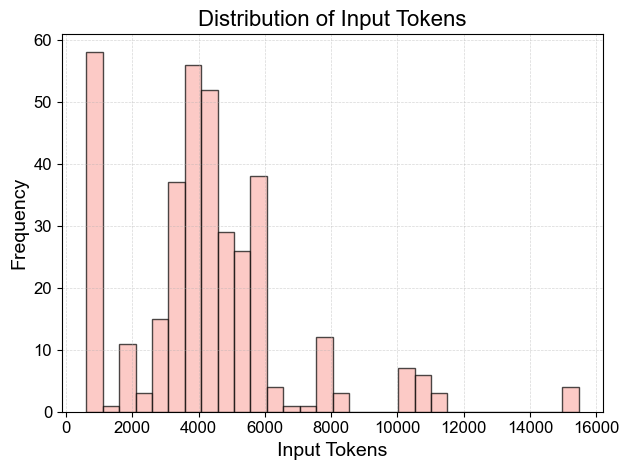

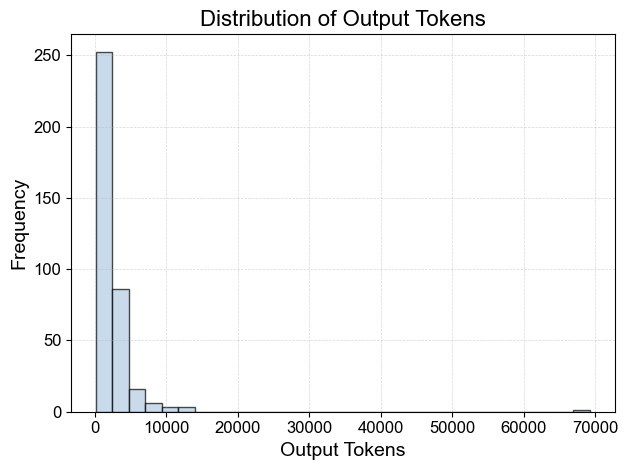

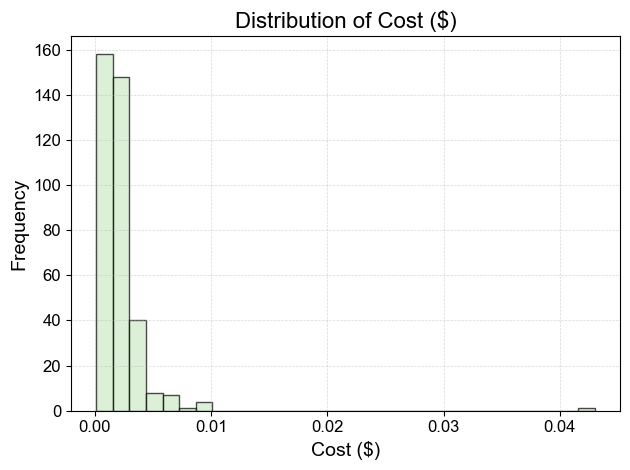

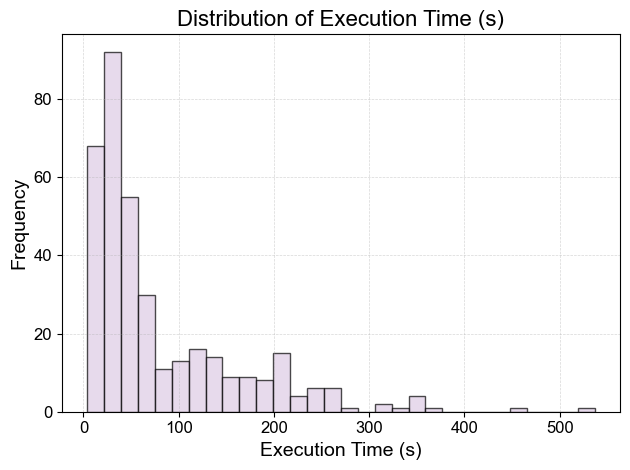

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']


# Load and preprocess data
records = []
with open('result/experiment_log.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        obj = json.loads(line)
        if 'instruction_key' in obj:
            records.append(obj)

df = pd.DataFrame(records)

# Extract result columns safely
df['input_tokens'] = df['result'].apply(lambda r: r[1] if isinstance(r, list) and len(r) > 1 else np.nan)
df['output_tokens'] = df['result'].apply(lambda r: r[2] if isinstance(r, list) and len(r) > 2 else np.nan)
df['cost'] = df['result'].apply(lambda r: r[3] if isinstance(r, list) and len(r) > 3 else np.nan)

# Filter only successful executions
df_success = df[df['status'] == 'success']

# Pastel color palette
colors = plt.get_cmap('Pastel1').colors

# Variables for histograms
variables = ['input_tokens', 'output_tokens', 'cost', 'execution_time']
titles = {
    'input_tokens': 'Input Tokens',
    'output_tokens': 'Output Tokens',
    'cost': 'Cost ($)',
    'execution_time': 'Execution Time (s)'
}

# Generate separate histograms for each variable
for i, var in enumerate(variables):
    plt.figure()
    data = df_success[var].dropna()
    plt.hist(data, bins=30, color=colors[i % len(colors)], edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {titles[var]}', fontsize=16)
    plt.xlabel(titles[var], fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()


üìä Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ
‚úÖ Ïã§Ìñâ ÏÑ±Í≥µÏú®: 96.57%

‚è± execution_time
  ÌèâÍ∑†: 78.365s, Î∂ÑÏÇ∞: 6092.210, Ìï©Í≥Ñ: 29700.392s

üìä input_tokens
  ÌèâÍ∑†: 3680.54, Î∂ÑÏÇ∞: 4724350.33, Ìï©Í≥Ñ: 1347079.00

üìä output_tokens
  ÌèâÍ∑†: 1889.51, Î∂ÑÏÇ∞: 1369383.69, Ìï©Í≥Ñ: 691561.00

üìä cost
  ÌèâÍ∑†: 0.00, Î∂ÑÏÇ∞: 0.00, Ìï©Í≥Ñ: 1.41

üî¢ ÏÉÅÌÉúÎ≥Ñ Í±¥Ïàò


status
success    366
error       13
Name: count, dtype: int64


üìù Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ


execution_time  input_tokens  output_tokens        cost
count      379.000000    366.000000     366.000000  366.000000
mean        78.365152   3680.543716    1889.510929    0.003839
std         78.052612   2173.557067    1170.206688    0.002791
min          3.393506    610.000000     159.000000    0.000094
25%         31.965200   2999.750000    1189.250000    0.002462
50%         49.642741   3645.500000    1738.500000    0.003650
75%        105.065194   4611.750000    2396.000000    0.005038
max        472.884686  12397.000000    8219.000000    0.017578



üìä Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÜµÍ≥Ñ

üî¢ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Îç∞Ïù¥ÌÑ∞ Í±¥Ïàò


category
VisualFormatting            123
TextEditing                 116
LayoutAndImageAdjustment     95
SlideStructure               45
Name: count, dtype: int64


‚úÖ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÑ±Í≥µÎ•†


category
LayoutAndImageAdjustment    97.894737
SlideStructure              91.111111
TextEditing                 98.275862
VisualFormatting            95.934959
Name: success_flag, dtype: float64


üìä Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌèâÍ∑†Í∞í


execution_time  input_tokens  output_tokens  \
category                                                                
LayoutAndImageAdjustment       89.859340   3991.516129    2095.419355   
SlideStructure                 74.390462   2243.170732    1284.024390   
TextEditing                    58.169952   3357.991228    1662.587719   
VisualFormatting               89.987560   4246.500000    2156.838983   

                              cost  
category                            
LayoutAndImageAdjustment  0.004337  
SlideStructure            0.002109  
TextEditing               0.003345  
VisualFormatting          0.004525


üìä Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Ìï©Í≥Ñ


execution_time  input_tokens  output_tokens  \
category                                                                
LayoutAndImageAdjustment     8536.637321      371211.0       194874.0   
SlideStructure               3347.570784       91970.0        52645.0   
TextEditing                  6747.714426      382811.0       189535.0   
VisualFormatting            11068.469928      501087.0       254507.0   

                              cost  
category                            
LayoutAndImageAdjustment  0.403309  
SlideStructure            0.086460  
TextEditing               0.381353  
VisualFormatting          0.534007

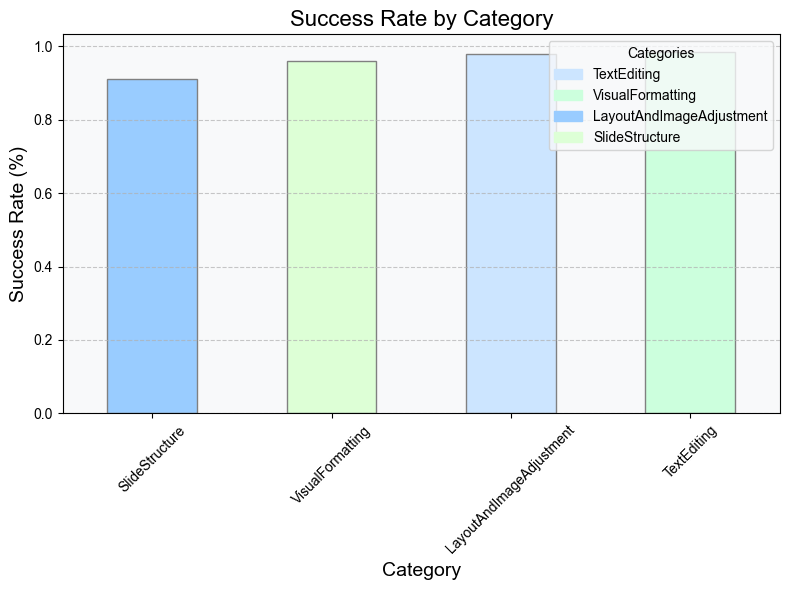

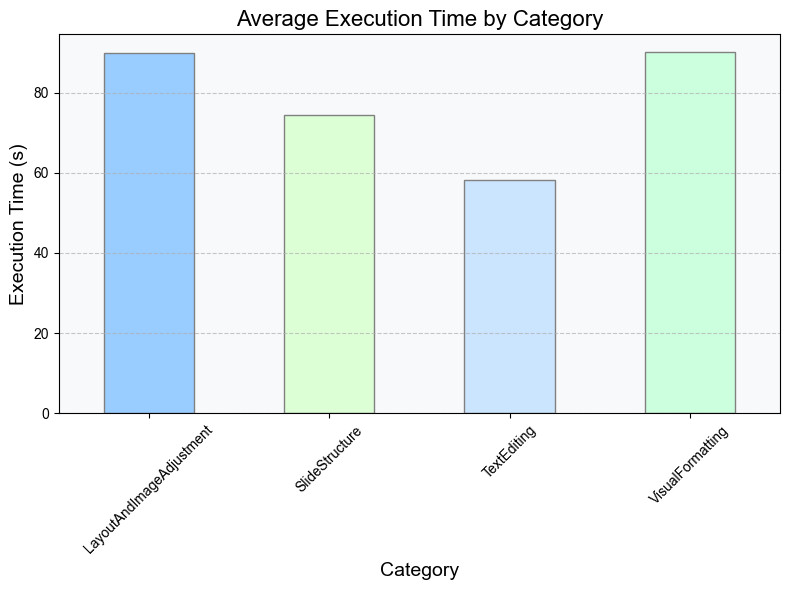

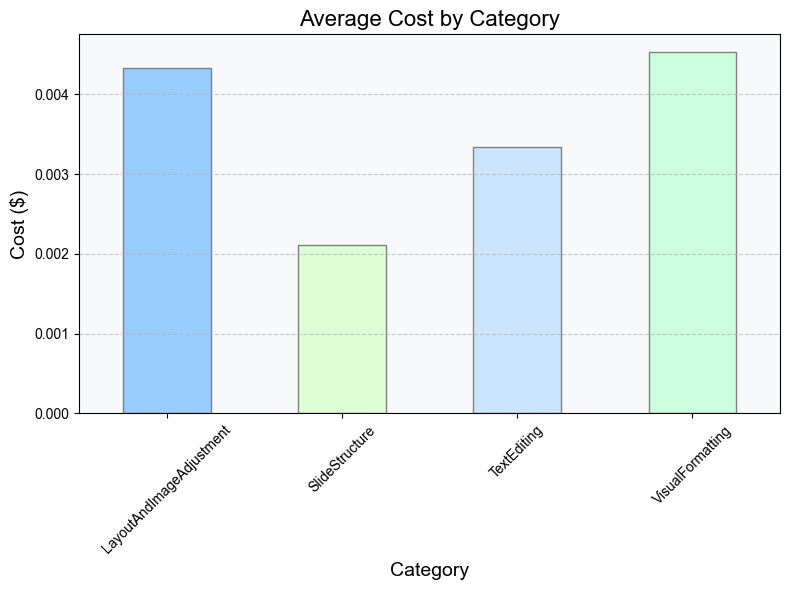

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21852\2937387902.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21852\2937387902.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21852\2937387902.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21852\2937387902.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is depre

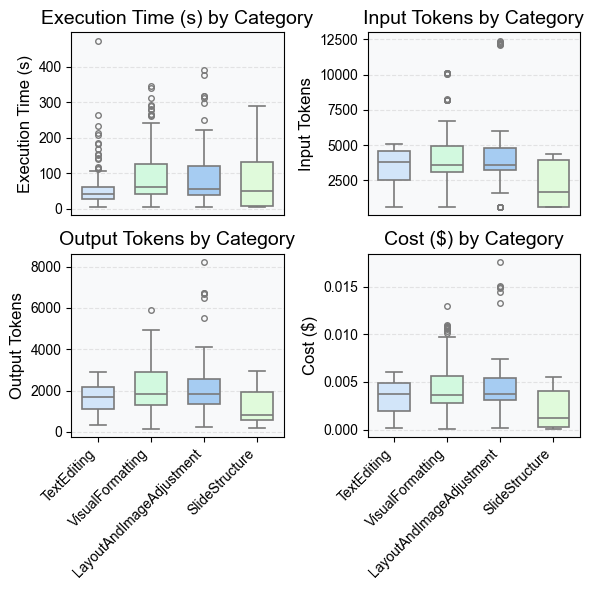


üìù Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÉÅÏÑ∏ ÌÜµÍ≥Ñ ÏöîÏïΩ


Category  Total Count  Success Count Success Rate (%)  \
0               TextEditing          116            114            98.28   
2  LayoutAndImageAdjustment           95             93            97.89   
1          VisualFormatting          123            118            95.93   
3            SlideStructure           45             41            91.11   

  Avg Execution Time (s) Avg Input Tokens Avg Output Tokens Avg Cost ($)  \
0                 58.715          3357.99           1662.59       0.0033   
2                 88.775          3991.52           2095.42       0.0043   
1                 93.530          4246.50           2156.84       0.0045   
3                 77.589          2243.17           1284.02       0.0021   

  Total Cost ($)  
0         0.3814  
2         0.4033  
1         0.5340  
3         0.0865

In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# ÏÖÄ 1: ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ Î∞è ÏãúÍ∞ÅÌôî ÏÑ§Ï†ï
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
plt.rcParams['figure.figsize'] = [10, 8]
# plt.style.use('seaborn-pastel')  # Ïò§ÎûòÎêú Ïä§ÌÉÄÏùº Ïù¥Î¶ÑÏúºÎ°ú Ïò§Î•ò Î∞úÏÉù

# ÌååÏä§ÌÖî ÏÉâÏÉÅ ÏÑ§Ï†ï (Î™®Îì† Í∑∏ÎûòÌîÑÏóê ÏùºÍ¥ÄÎêòÍ≤å Ï†ÅÏö©)
pastel_colors = {
    'TextEditing': '#CCE5FF',        # Ïó∞Ìïú ÌïòÎäòÏÉâ
    'VisualFormatting': '#CCFFDD',   # Ïó∞Ìïú ÎØºÌä∏ÏÉâ
    'LayoutAndImageAdjustment': '#99CCFF',  # Î∞ùÏùÄ ÌååÎûëÏÉâ
    'SlideStructure': '#DDFFD6'      # Ïó∞Ìïú Ïó∞ÎëêÏÉâ
}

# Í∑∏ÎûòÌîÑ ÎîîÏûêÏù∏ Í∞úÏÑ†ÏùÑ ÏúÑÌïú ÏÑ§Ï†ï
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# ÏÖÄ 2: JSONL ÌååÏùº Î°úÎìú Ìï®Ïàò Ï†ïÏùò Î∞è Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
def load_jsonl(filepath):
    """JSONL ÌååÏùºÏùÑ ÏùΩÏñ¥ pandas.DataFrame ÏúºÎ°ú Î∞òÌôò"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            if 'instruction_key' in obj:
                records.append(obj)
    return pd.DataFrame(records)

# instruction_keyÏóê ÎåÄÌïú Ïπ¥ÌÖåÍ≥†Î¶¨ Îß§Ìïë Ï†ïÏùò
category_map = {
  "0": "TextEditing", "1": "TextEditing", "2": "TextEditing", 
  "3": "TextEditing", "4": "TextEditing", "5": "TextEditing",
  "6": "TextEditing", "7": "TextEditing", "8": "TextEditing",
  "9": "TextEditing", "10": "TextEditing", "11": "VisualFormatting",
  "12": "VisualFormatting", "13": "TextEditing", "14": "VisualFormatting",
  "15": "TextEditing", "16": "VisualFormatting", "17": "LayoutAndImageAdjustment",
  "18": "VisualFormatting", "19": "TextEditing", "20": "VisualFormatting",
  "21": "VisualFormatting", "22": "VisualFormatting", "23": "VisualFormatting",
  "24": "VisualFormatting", "25": "VisualFormatting", "26": "VisualFormatting",
  "27": "VisualFormatting", "28": "VisualFormatting", "29": "LayoutAndImageAdjustment",
  "30": "LayoutAndImageAdjustment", "31": "LayoutAndImageAdjustment", "32": "LayoutAndImageAdjustment",
  "33": "LayoutAndImageAdjustment", "34": "LayoutAndImageAdjustment", "35": "LayoutAndImageAdjustment",
  "36": "LayoutAndImageAdjustment", "37": "LayoutAndImageAdjustment", "38": "LayoutAndImageAdjustment",
  "39": "LayoutAndImageAdjustment", "40": "VisualFormatting", "41": "VisualFormatting",
  "42": "VisualFormatting", "43": "LayoutAndImageAdjustment", "44": "LayoutAndImageAdjustment",
  "45": "VisualFormatting", "46": "SlideStructure", "47": "SlideStructure",
  "48": "SlideStructure", "49": "LayoutAndImageAdjustment", "50": "SlideStructure",
  "51": "SlideStructure", "52": "SlideStructure", "53": "VisualFormatting",
  "54": "TextEditing", "55": "TextEditing"
}

# ÏÖÄ 3: Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
df = load_jsonl("result_gpt4-1/experiment_log.jsonl")

# instruction_keyÏóêÏÑú Ïπ¥ÌÖåÍ≥†Î¶¨ Ï∂îÏ∂ú (2-2ÏôÄ Í∞ôÏù¥ ÌïòÏù¥ÌîàÏù¥ ÏûàÎäî Í≤ΩÏö∞ Ï≤´ Î≤àÏß∏ Ïà´ÏûêÎßå ÏÇ¨Ïö©)
def get_category(key):
    # ÌïòÏù¥ÌîàÏù¥ ÏûàÏúºÎ©¥ Ï≤´ Î∂ÄÎ∂ÑÎßå Ï∂îÏ∂ú
    base_key = key.split('-')[0] if '-' in key else key
    return category_map.get(base_key, "Unknown")

# Ïπ¥ÌÖåÍ≥†Î¶¨ Ïª¨Îüº Ï∂îÍ∞Ä
df['category'] = df['instruction_key'].apply(get_category)

# 'result' Ïª¨Îüº Î∂ÑÌï¥ Î∞è ÏÑ±Í≥µ ÌîåÎûòÍ∑∏ ÏÉùÏÑ±
df['success_flag'] = df['status'] == 'success'

# ÏïàÏ†ÑÌïòÍ≤å result Î¶¨Ïä§Ìä∏ÏóêÏÑú ÌÜ†ÌÅ∞¬∑ÎπÑÏö© Î∂ÑÎ¶¨
df['input_tokens'] = df['result'].apply(
    lambda r: r[1] if isinstance(r, list) and len(r) > 1 else np.nan
)
df['output_tokens'] = df['result'].apply(
    lambda r: r[2] if isinstance(r, list) and len(r) > 2 else np.nan
)
df['cost'] = df['result'].apply(
    lambda r: r[3] if isinstance(r, list) and len(r) > 3 else np.nan
)

# ÏÖÄ 4: Ï†ÑÏ≤¥ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞ Î∞è Ï∂úÎ†•
print("üìä Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ\n" + "="*50)

# 1) Ïã§Ìñâ ÏÑ±Í≥µÏú®
success_rate = df['success_flag'].mean()

# 2) execution_time ÌÜµÍ≥Ñ
exec_mean = df['execution_time'].mean()
exec_var  = df['execution_time'].var()
exec_sum  = df['execution_time'].sum()

# 3) ÌÜ†ÌÅ∞¬∑ÎπÑÏö© ÌÜµÍ≥Ñ
stats = {}
for col in ['input_tokens','output_tokens','cost']:
    stats[col] = {
        'mean': df[col].mean(),
        'var' : df[col].var(),
        'sum' : df[col].sum()
    }

# 4) Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ
summary = df[['execution_time','input_tokens','output_tokens','cost']].describe()

# 5) ÏÉÅÌÉúÎ≥Ñ Í±¥Ïàò
counts_by_status = df['status'].value_counts()

# Í≤∞Í≥º Ï∂úÎ†•
print(f"‚úÖ Ïã§Ìñâ ÏÑ±Í≥µÏú®: {success_rate*100:.2f}%\n")

print("‚è± execution_time")
print(f"  ÌèâÍ∑†: {exec_mean:.3f}s, Î∂ÑÏÇ∞: {exec_var:.3f}, Ìï©Í≥Ñ: {exec_sum:.3f}s\n")

for col, v in stats.items():
    print(f"üìä {col}")
    print(f"  ÌèâÍ∑†: {v['mean']:.2f}, Î∂ÑÏÇ∞: {v['var']:.2f}, Ìï©Í≥Ñ: {v['sum']:.2f}\n")

print("üî¢ ÏÉÅÌÉúÎ≥Ñ Í±¥Ïàò")
display(counts_by_status)

print("\nüìù Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ")
display(summary)

# ÏÖÄ 5: Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
print("\n\nüìä Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÜµÍ≥Ñ\n" + "="*50)

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Îç∞Ïù¥ÌÑ∞ Ïàò
category_counts = df['category'].value_counts()
print("\nüî¢ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Îç∞Ïù¥ÌÑ∞ Í±¥Ïàò")
display(category_counts)

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÑ±Í≥µÎ•†
category_success = df.groupby('category')['success_flag'].mean()
print("\n‚úÖ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÑ±Í≥µÎ•†")
display(category_success * 100)

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌèâÍ∑† ÌÜµÍ≥Ñ
category_stats = df.groupby('category')[['execution_time', 'input_tokens', 'output_tokens', 'cost']].mean()
print("\nüìä Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌèâÍ∑†Í∞í")
display(category_stats)

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Ìï©Í≥Ñ ÌÜµÍ≥Ñ
category_sums = df.groupby('category')[['execution_time', 'input_tokens', 'output_tokens', 'cost']].sum()
print("\nüìä Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Ìï©Í≥Ñ")
display(category_sums)

# ÏÖÄ 6: Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏãúÍ∞ÅÌôî (ÌååÏä§ÌÖî ÏÉâÏÉÅÏúºÎ°ú ÌÜµÏùº)

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÑ±Í≥µÎ•† ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
ax = category_success.sort_values().plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_success.index],
    edgecolor='gray'
)
plt.title('Success Rate by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Î≤îÎ°Ä Ï∂îÍ∞Ä
handles = [plt.Rectangle((0,0),1,1, color=pastel_colors[cat]) for cat in pastel_colors.keys()]
plt.legend(handles, pastel_colors.keys(), title="Categories")

plt.tight_layout()
plt.show()

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌèâÍ∑† Ïã§Ìñâ ÏãúÍ∞Ñ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
ax = category_stats['execution_time'].plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_stats.index],
    edgecolor='gray'
)
plt.title('Average Execution Time by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Execution Time (s)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌèâÍ∑† ÎπÑÏö© ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
ax = category_stats['cost'].plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_stats.index],
    edgecolor='gray'
)
plt.title('Average Cost by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Cost ($)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ÏÖÄ 7: Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Î∞ïÏä§ÌîåÎ°Ø ÎπÑÍµê (ÌååÏä§ÌÖî ÏÉâÏÉÅ Ï†ÅÏö©)
# Ï£ºÏöî Î©îÌä∏Î¶≠Ïóê ÎåÄÌïú Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Î∞ïÏä§ÌîåÎ°Ø
metrics = ['execution_time', 'input_tokens', 'output_tokens', 'cost']
titles = {
    'execution_time': 'Execution Time (s)',
    'input_tokens': 'Input Tokens',
    'output_tokens': 'Output Tokens',
    'cost': 'Cost ($)'
}

# Ïª§Ïä§ÌÖÄ ÌååÏä§ÌÖî ÌåîÎ†àÌä∏Î•º seabornÏóê Ï†ÑÎã¨Ìï† ÌòïÌÉúÎ°ú Î≥ÄÌôò
custom_palette = list(pastel_colors.values())

plt.figure(figsize=(6, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    # ÏÑ±Í≥µÌïú ÏºÄÏù¥Ïä§Îßå ÏÑ†ÌÉù
    success_df = df[df['success_flag']]
    
    # ÌååÏä§ÌÖî Ïª¨Îü¨ Ï†ÅÏö©
    ax = sns.boxplot(
        x='category', 
        y=metric, 
        data=success_df, 
        palette=custom_palette,
        width=0.6,
        linewidth=1.2,
        fliersize=4
    )
    
    plt.title(f'{titles[metric]} by Category', fontsize=14)
    plt.xlabel('', fontsize=12)  # xÏ∂ï Î†àÏù¥Î∏î Ïà®ÍπÄ (Í≥µÍ∞Ñ Ï†àÏïΩ)
    plt.ylabel(titles[metric], fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # xÏ∂ï Î†àÏù¥Î∏î Í∞ÄÎèÖÏÑ± Ìñ•ÏÉÅ
    if i > 2:  # ÌïòÎã® subplotÏóêÎßå Ïπ¥ÌÖåÍ≥†Î¶¨ Î†àÏù¥Î∏î ÌëúÏãú
        plt.xticks(rotation=45, ha='right')
    else:
        plt.xticks([])  # ÏÉÅÎã® subplotÏóêÏÑúÎäî xÏ∂ï Î†àÏù¥Î∏î Ïà®ÍπÄ
        
    # Î∞∞Í≤ΩÏóê ÏïΩÍ∞ÑÏùò Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
    ax.set_axisbelow(True)
    
plt.tight_layout()
plt.show()

# ÏÖÄ 8: ÏÉÅÏÑ∏ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÜµÍ≥Ñ ÌÖåÏù¥Î∏î ÏÉùÏÑ±
# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÉÅÏÑ∏ ÌÜµÍ≥Ñ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
detailed_stats = []

for category in df['category'].unique():
    cat_df = df[df['category'] == category]
    cat_success = cat_df['success_flag'].mean()
    
    # ÏÑ±Í≥µÌïú ÏºÄÏù¥Ïä§Îßå ÏÑ†ÌÉùÌïòÏó¨ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
    cat_success_df = cat_df[cat_df['success_flag']]
    
    # Í∏∞Î≥∏ ÌÜµÍ≥Ñ Ï∂îÏ∂ú
    stat = {
        'Category': category,
        'Total Count': len(cat_df),
        'Success Count': len(cat_success_df),
        'Success Rate (%)': cat_success * 100,
        'Avg Execution Time (s)': cat_success_df['execution_time'].mean(),
        'Avg Input Tokens': cat_success_df['input_tokens'].mean(),
        'Avg Output Tokens': cat_success_df['output_tokens'].mean(),
        'Avg Cost ($)': cat_success_df['cost'].mean(),
        'Total Cost ($)': cat_success_df['cost'].sum()
    }
    detailed_stats.append(stat)

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥† ÏÑ±Í≥µÎ•† Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
detailed_df = pd.DataFrame(detailed_stats).sort_values('Success Rate (%)', ascending=False)

# ÏÜåÏàòÏ†ê Ìè¨Îß∑ÌåÖ
format_dict = {
    'Success Rate (%)': '{:.2f}',
    'Avg Execution Time (s)': '{:.3f}',
    'Avg Input Tokens': '{:.2f}',
    'Avg Output Tokens': '{:.2f}',
    'Avg Cost ($)': '{:.4f}',
    'Total Cost ($)': '{:.4f}'
}

# Ìè¨Îß∑ÌåÖ Ï†ÅÏö©
for col, fmt in format_dict.items():
    detailed_df[col] = detailed_df[col].apply(lambda x: fmt.format(x))

print("\nüìù Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÉÅÏÑ∏ ÌÜµÍ≥Ñ ÏöîÏïΩ")
display(detailed_df)

In [ ]:
%pip install seaborn

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ÌååÏä§ÌÖî ÏÉâÏÉÅ ÏÑ§Ï†ï (Î™®Îì† Í∑∏ÎûòÌîÑÏóê ÏùºÍ¥ÄÎêòÍ≤å Ï†ÅÏö©)
pastel_colors = {
    'TextEditing': '#CCE5FF',        # Ïó∞Ìïú ÌïòÎäòÏÉâ
    'VisualFormatting': '#CCFFDD',   # Ïó∞Ìïú ÎØºÌä∏ÏÉâ
    'LayoutAndImageAdjustment': '#99CCFF',  # Î∞ùÏùÄ ÌååÎûëÏÉâ
    'SlideStructure': '#DDFFD6'      # Ïó∞Ìïú Ïó∞ÎëêÏÉâ
}

# Í∑∏ÎûòÌîÑ ÎîîÏûêÏù∏ Í∞úÏÑ†ÏùÑ ÏúÑÌïú ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# JSONL ÌååÏùº Î°úÎìú Ìï®Ïàò Ï†ïÏùò Î∞è Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
def load_jsonl(filepath):
    """JSONL ÌååÏùºÏùÑ ÏùΩÏñ¥ pandas.DataFrame ÏúºÎ°ú Î∞òÌôò"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            if 'instruction_key' in obj:
                records.append(obj)
    return pd.DataFrame(records)

# instruction_keyÏóê ÎåÄÌïú Ïπ¥ÌÖåÍ≥†Î¶¨ Îß§Ìïë Ï†ïÏùò
category_map = {
  "0": "TextEditing", "1": "TextEditing", "2": "TextEditing", 
  "3": "TextEditing", "4": "TextEditing", "5": "TextEditing",
  "6": "TextEditing", "7": "TextEditing", "8": "TextEditing",
  "9": "TextEditing", "10": "TextEditing", "11": "VisualFormatting",
  "12": "VisualFormatting", "13": "TextEditing", "14": "VisualFormatting",
  "15": "TextEditing", "16": "VisualFormatting", "17": "LayoutAndImageAdjustment",
  "18": "VisualFormatting", "19": "TextEditing", "20": "VisualFormatting",
  "21": "VisualFormatting", "22": "VisualFormatting", "23": "VisualFormatting",
  "24": "VisualFormatting", "25": "VisualFormatting", "26": "VisualFormatting",
  "27": "VisualFormatting", "28": "VisualFormatting", "29": "LayoutAndImageAdjustment",
  "30": "LayoutAndImageAdjustment", "31": "LayoutAndImageAdjustment", "32": "LayoutAndImageAdjustment",
  "33": "LayoutAndImageAdjustment", "34": "LayoutAndImageAdjustment", "35": "LayoutAndImageAdjustment",
  "36": "LayoutAndImageAdjustment", "37": "LayoutAndImageAdjustment", "38": "LayoutAndImageAdjustment",
  "39": "LayoutAndImageAdjustment", "40": "VisualFormatting", "41": "VisualFormatting",
  "42": "VisualFormatting", "43": "LayoutAndImageAdjustment", "44": "LayoutAndImageAdjustment",
  "45": "VisualFormatting", "46": "SlideStructure", "47": "SlideStructure",
  "48": "SlideStructure", "49": "LayoutAndImageAdjustment", "50": "SlideStructure",
  "51": "SlideStructure", "52": "SlideStructure", "53": "VisualFormatting",
  "54": "TextEditing", "55": "TextEditing"
}

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
df = load_jsonl("result/experiment_log.jsonl")

# instruction_keyÏóêÏÑú Ïπ¥ÌÖåÍ≥†Î¶¨ Ï∂îÏ∂ú (2-2ÏôÄ Í∞ôÏù¥ ÌïòÏù¥ÌîàÏù¥ ÏûàÎäî Í≤ΩÏö∞ Ï≤´ Î≤àÏß∏ Ïà´ÏûêÎßå ÏÇ¨Ïö©)
def get_category(key):
    # ÌïòÏù¥ÌîàÏù¥ ÏûàÏúºÎ©¥ Ï≤´ Î∂ÄÎ∂ÑÎßå Ï∂îÏ∂ú
    base_key = key.split('-')[0] if '-' in key else key
    return category_map.get(base_key, "Unknown")

# Ïπ¥ÌÖåÍ≥†Î¶¨ Ïª¨Îüº Ï∂îÍ∞Ä
df['category'] = df['instruction_key'].apply(get_category)

# 'result' Ïª¨Îüº Î∂ÑÌï¥ Î∞è ÏÑ±Í≥µ ÌîåÎûòÍ∑∏ ÏÉùÏÑ±
df['success_flag'] = df['status'] == 'success'

# ÏïàÏ†ÑÌïòÍ≤å result Î¶¨Ïä§Ìä∏ÏóêÏÑú ÌÜ†ÌÅ∞¬∑ÎπÑÏö© Î∂ÑÎ¶¨
df['input_tokens'] = df['result'].apply(
    lambda r: r[1] if isinstance(r, list) and len(r) > 1 else np.nan
)
df['output_tokens'] = df['result'].apply(
    lambda r: r[2] if isinstance(r, list) and len(r) > 2 else np.nan
)
df['cost'] = df['result'].apply(
    lambda r: r[3] if isinstance(r, list) and len(r) > 3 else np.nan
)

# ÏÑ±Í≥µÌïú ÏºÄÏù¥Ïä§Îßå ÏÑ†ÌÉù
success_df = df[df['success_flag']]

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìï®Ïàò Ï†ïÏùò
def remove_outliers(df, category, column, method='iqr', threshold=3.0):
    """
    ÌäπÏ†ï Ïπ¥ÌÖåÍ≥†Î¶¨ÎÇ¥Ïùò Ïó¥ÏóêÏÑú Ïù¥ÏÉÅÏπòÎ•º Ï†úÍ±∞ÌïòÎäî Ìï®Ïàò
    
    Parameters:
    -----------
    df : DataFrame
        ÎåÄÏÉÅ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    category : str
        Ïù¥ÏÉÅÏπòÎ•º Ï†úÍ±∞Ìï† Ïπ¥ÌÖåÍ≥†Î¶¨Î™Ö
    column : str
        Ïù¥ÏÉÅÏπòÎ•º Ï†úÍ±∞Ìï† Ïó¥ Ïù¥Î¶Ñ
    method : str, ÏòµÏÖò ('iqr' ÎòêÎäî 'zscore')
        Ïù¥ÏÉÅÏπò ÌÉêÏßÄ Î∞©Î≤ï
    threshold : float
        Ïù¥ÏÉÅÏπò ÌåêÎ≥Ñ ÏûÑÍ≥ÑÍ∞í (IQR Î∞©ÏãùÏóêÏÑúÎäî Î∞∞Ïàò, Z-score Î∞©ÏãùÏóêÏÑúÎäî ÌëúÏ§ÄÌé∏Ï∞®)
        
    Returns:
    --------
    DataFrame
        Ïù¥ÏÉÅÏπòÍ∞Ä Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    """
    # Ïπ¥ÌÖåÍ≥†Î¶¨Ïóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
    cat_df = df[df['category'] == category].copy()
    
    if method == 'iqr':
        # IQR Î∞©Ïãù (ÏÇ¨Î∂ÑÏúÑÏàò Î≤îÏúÑÏùò Î∞∞ÏàòÎ•º ÏÇ¨Ïö©)
        Q1 = cat_df[column].quantile(0.25)
        Q3 = cat_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Ïù¥ÏÉÅÏπò ÏãùÎ≥Ñ
        outliers = (cat_df[column] < lower_bound) | (cat_df[column] > upper_bound)
        
    elif method == 'zscore':
        # Z-score Î∞©Ïãù (ÌèâÍ∑†ÏúºÎ°úÎ∂ÄÌÑ∞ ÌëúÏ§ÄÌé∏Ï∞®Ïùò Î∞∞ÏàòÎ•º ÏÇ¨Ïö©)
        mean = cat_df[column].mean()
        std = cat_df[column].std()
        z_scores = abs((cat_df[column] - mean) / std)
        outliers = z_scores > threshold
    
    else:
        raise ValueError(f"ÏßÄÏõêÎêòÏßÄ ÏïäÎäî Î∞©Î≤ï: {method}")
    
    # Ïù¥ÏÉÅÏπò Ï†ïÎ≥¥ Ï∂úÎ†•
    if outliers.any():
        print(f"‚ö†Ô∏è '{category}' Ïπ¥ÌÖåÍ≥†Î¶¨Ïùò '{column}' Ïó¥ÏóêÏÑú {outliers.sum()}Í∞úÏùò Ïù¥ÏÉÅÏπò Î∞úÍ≤¨Îê®")
        print(f"  - Ïù¥ÏÉÅÏπò Í∞í: {cat_df.loc[outliers, column].values}")
    
    # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú Ìï¥Îãπ Ïπ¥ÌÖåÍ≥†Î¶¨Ïùò Ïù¥ÏÉÅÏπò Ï†úÍ±∞
    result_df = df.copy()
    cat_indices = result_df[result_df['category'] == category].index
    outlier_indices = cat_df.loc[outliers].index
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î∞òÌôò
    return result_df[~result_df.index.isin(outlier_indices)]

# 'VisualFormatting' Ïπ¥ÌÖåÍ≥†Î¶¨ÏóêÏÑú 'output_tokens'ÏôÄ 'cost'Ïùò Ïù¥ÏÉÅÏπò Ï†úÍ±∞
# IQR Î∞©Ïãù ÏÇ¨Ïö©, Ïù¥ÏÉÅÏπò Í∏∞Ï§ÄÏùÄ IQRÏùò 3Î∞∞Î°ú ÏÑ§Ï†ï
print("\nüîç Ïù¥ÏÉÅÏπò ÌÉêÏßÄ Î∞è Ï†úÍ±∞")
print("="*50)

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ï†Ñ ÌÜµÍ≥Ñ ÌôïÏù∏
print("\n‚ñ∂Ô∏è Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ï†Ñ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ output_tokens ÌÜµÍ≥Ñ:")
vf_before = success_df[success_df['category'] == 'VisualFormatting']['output_tokens']
print(f"VisualFormatting output_tokens ÏµúÎåÄÍ∞í: {vf_before.max()}")
print(f"VisualFormatting output_tokens ÌèâÍ∑†Í∞í: {vf_before.mean()}")

# Îç∞Ïù¥ÌÑ∞ Î≥µÏÇ¨ - outlierÎ•º Ï†úÍ±∞Ìïú ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
filtered_df = remove_outliers(success_df, 'VisualFormatting', 'output_tokens', method='iqr', threshold=1.5)

# ÌïÑÌÑ∞ÎßÅÎêú Îç∞Ïù¥ÌÑ∞Î°ú ÎπÑÏö© Ïù¥ÏÉÅÏπòÎèÑ Ï†úÍ±∞ (ÌÜµÏÉÅ ÌÜ†ÌÅ∞Í≥º ÎπÑÏö©ÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏùå)
# Î≥ÑÎèÑ ÌïÑÌÑ∞ÎßÅÏù¥ ÌïÑÏöîÌïòÎ©¥ ÏïÑÎûò Ï£ºÏÑù Ìï¥Ï†ú
# filtered_df = remove_outliers(filtered_df, 'VisualFormatting', 'cost', method='iqr', threshold=1.5)

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ ÌÜµÍ≥Ñ ÌôïÏù∏
print("\n‚ñ∂Ô∏è Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ output_tokens ÌÜµÍ≥Ñ:")
vf_after = filtered_df[filtered_df['category'] == 'VisualFormatting']['output_tokens']
print(f"VisualFormatting output_tokens ÏµúÎåÄÍ∞í: {vf_after.max()}")
print(f"VisualFormatting output_tokens ÌèâÍ∑†Í∞í: {vf_after.mean()}")

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÜµÍ≥Ñ Îã§Ïãú Í≥ÑÏÇ∞ (Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ)
category_stats_filtered = filtered_df.groupby('category')[['execution_time', 'input_tokens', 'output_tokens', 'cost']].mean()

print("\nüìä Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌèâÍ∑†Í∞í")
display(category_stats_filtered)

# ---------------------- Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ ÏãúÍ∞ÅÌôî -----------------------
print("\nüìà Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ ÏãúÍ∞ÅÌôî")
print("="*50)

# 1. Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌèâÍ∑† Ï∂úÎ†• ÌÜ†ÌÅ∞ ÏãúÍ∞ÅÌôî (Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ)
plt.figure(figsize=(10, 6))
ax = category_stats_filtered['output_tokens'].plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_stats_filtered.index],
    edgecolor='gray'
)
plt.title('Average Output Tokens by Category (Outliers Removed)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Output Tokens', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Î≤îÎ°Ä Ï∂îÍ∞Ä
handles = [plt.Rectangle((0,0),1,1, color=pastel_colors[cat]) for cat in pastel_colors.keys()]
plt.legend(handles, pastel_colors.keys(), title="Categories")

plt.tight_layout()
plt.show()

# 2. Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌèâÍ∑† ÎπÑÏö© ÏãúÍ∞ÅÌôî (Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ)
plt.figure(figsize=(10, 6))
ax = category_stats_filtered['cost'].plot(
    kind='bar', 
    color=[pastel_colors[cat] for cat in category_stats_filtered.index],
    edgecolor='gray'
)
plt.title('Average Cost by Category (Outliers Removed)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Cost ($)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. ÏóÖÎç∞Ïù¥Ìä∏Îêú Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Î∞ïÏä§ÌîåÎ°Ø ÎπÑÍµê (Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ)
metrics = ['execution_time', 'input_tokens', 'output_tokens', 'cost']
titles = {
    'execution_time': 'Execution Time (s)',
    'input_tokens': 'Input Tokens',
    'output_tokens': 'Output Tokens (Outliers Removed)',
    'cost': 'Cost ($) (Outliers Removed)'
}

# Ïª§Ïä§ÌÖÄ ÌååÏä§ÌÖî ÌåîÎ†àÌä∏Î•º seabornÏóê Ï†ÑÎã¨Ìï† ÌòïÌÉúÎ°ú Î≥ÄÌôò
custom_palette = list(pastel_colors.values())

plt.figure(figsize=(6, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    
    # ÌååÏä§ÌÖî Ïª¨Îü¨ Ï†ÅÏö©, showfliers=FalseÎ°ú Î∞ïÏä§ÌîåÎ°ØÏùò Ïù¥ÏÉÅÏπò ÌëúÏãú Ï†úÍ±∞
    # whis Îß§Í∞úÎ≥ÄÏàòÎ•º ÎÇÆÍ≤å ÏÑ§Ï†ïÌï¥ Îçî ÏóÑÍ≤©ÌïòÍ≤å Ïù¥ÏÉÅÏπò ÌåêÎ≥Ñ (Í∏∞Î≥∏Í∞íÏùÄ 1.5)
    ax = sns.boxplot(
        x='category', 
        y=metric, 
        data=filtered_df, 
        palette=custom_palette,
        width=0.6,
        linewidth=1.2,
        showfliers=(metric not in ['output_tokens', 'cost']),  # output_tokensÏôÄ costÏóêÏÑúÎäî Ïù¥ÏÉÅÏπò ÌëúÏãú Ï†úÍ±∞
        whis=1.5
    )
    
    plt.title(f'{titles[metric]}', fontsize=14)
    plt.xlabel('', fontsize=12)  # xÏ∂ï Î†àÏù¥Î∏î Ïà®ÍπÄ (Í≥µÍ∞Ñ Ï†àÏïΩ)
    plt.ylabel(titles[metric], fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # xÏ∂ï Î†àÏù¥Î∏î Í∞ÄÎèÖÏÑ± Ìñ•ÏÉÅ
    if i > 2:  # ÌïòÎã® subplotÏóêÎßå Ïπ¥ÌÖåÍ≥†Î¶¨ Î†àÏù¥Î∏î ÌëúÏãú
        plt.xticks(rotation=45, ha='right')
    else:
        plt.xticks([])  # ÏÉÅÎã® subplotÏóêÏÑúÎäî xÏ∂ï Î†àÏù¥Î∏î Ïà®ÍπÄ
        
    # Î∞∞Í≤ΩÏóê ÏïΩÍ∞ÑÏùò Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä
    ax.set_axisbelow(True)
    
plt.tight_layout()
plt.show()

# 4. Ïù¥ÏÉÅÏπò Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî (VisualFormatting Ïπ¥ÌÖåÍ≥†Î¶¨)
# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Ïùò VisualFormatting Ïπ¥ÌÖåÍ≥†Î¶¨ Ï∂úÎ†• ÌÜ†ÌÅ∞ Î∂ÑÌè¨
plt.figure(figsize=(12, 6))

# Ï≤´ Î≤àÏß∏ ÏÑúÎ∏åÌîåÎ°Ø: VisualFormatting Ïπ¥ÌÖåÍ≥†Î¶¨Ïùò Ï∂úÎ†• ÌÜ†ÌÅ∞ Î∂ÑÌè¨ (Ïù¥ÏÉÅÏπò Ìè¨Ìï®)
plt.subplot(1, 2, 1)
vf_data = success_df[success_df['category'] == 'VisualFormatting']['output_tokens']
plt.hist(vf_data, bins=20, color=pastel_colors['VisualFormatting'], edgecolor='gray')
plt.title('Output Tokens in VisualFormatting\n(with outliers)', fontsize=14)
plt.xlabel('Output Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Îëê Î≤àÏß∏ ÏÑúÎ∏åÌîåÎ°Ø: VisualFormatting Ïπ¥ÌÖåÍ≥†Î¶¨Ïùò Ï∂úÎ†• ÌÜ†ÌÅ∞ Î∂ÑÌè¨ (Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ)
plt.subplot(1, 2, 2)
vf_filtered = filtered_df[filtered_df['category'] == 'VisualFormatting']['output_tokens']
plt.hist(vf_filtered, bins=20, color=pastel_colors['VisualFormatting'], edgecolor='gray')
plt.title('Output Tokens in VisualFormatting\n(outliers removed)', fontsize=14)
plt.xlabel('Output Tokens', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Ïù¥ÏÉÅÏπòÎ•º ÌôïÏù∏ÌïòÍ∏∞ ÏúÑÌïú Ïä§Ï∫êÌÑ∞ ÌîåÎ°Ø (Ï∂úÎ†• ÌÜ†ÌÅ∞ vs ÎπÑÏö©)
plt.figure(figsize=(10, 6))
colors = [pastel_colors.get(cat, '#CCCCCC') for cat in success_df['category']]

plt.scatter(
    success_df['output_tokens'], 
    success_df['cost'],
    c=colors,
    alpha=0.7,
    edgecolor='gray'
)

# Ï†úÍ±∞Îêú Ïù¥ÏÉÅÏπò Í∞ïÏ°∞ ÌëúÏãú
outlier_indices = set(success_df.index) - set(filtered_df.index)
outliers = success_df.loc[list(outlier_indices)]  # ÏßëÌï©(set)ÏùÑ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
if not outliers.empty:
    plt.scatter(
        outliers['output_tokens'],
        outliers['cost'],
        c='red',
        s=100,
        marker='x',
        label='Removed Outliers'
    )

plt.title('Output Tokens vs Cost (Outliers Highlighted)', fontsize=16)
plt.xlabel('Output Tokens', fontsize=14)
plt.ylabel('Cost ($)', fontsize=14)
plt.grid(linestyle='--', alpha=0.3)

# Î≤îÎ°Ä Ï∂îÍ∞Ä
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in pastel_colors.values()]
labels = pastel_colors.keys()
plt.legend(handles + [plt.Line2D([0], [0], marker='x', color='red', markersize=10, linestyle='None')], 
           list(labels) + ['Outliers'], title="Categories")

plt.tight_layout()
plt.show()

# GPT Judge Ï§ÄÎπÑ

## slide image Ï∂îÏ∂ú

In [2]:
import os
from win32com import client

def export_slide_images(ppt_path, out_dir, width=1024, height=576):
    """
    Exports each slide of the given PPTX to a PNG image.
    Uses absolute paths so that PowerPoint COM can find the output folder.
    """
    ppt_app = client.Dispatch("PowerPoint.Application")
    # Open(FileName, ReadOnly, Untitled, WithWindow)
    presentation = ppt_app.Presentations.Open(
        os.path.abspath(ppt_path),
        False,   # ReadOnly
        True,    # Untitled
        False    # WithWindow
    )

    abs_out_dir = os.path.abspath(out_dir)
    os.makedirs(abs_out_dir, exist_ok=True)

    # Get slide count before exporting
    slide_count = presentation.Slides.Count
    
    for idx, slide in enumerate(presentation.Slides, start=1):
        image_path = os.path.join(abs_out_dir, f"slide_{idx:02}.png")
        # slide.Export(FileName, FilterName, ScaleWidth, ScaleHeight)
        slide.Export(image_path, "PNG", width, height)

    presentation.Close()
    ppt_app.Quit()
    
    print(f"  Exported {slide_count} slides")

if __name__ == "__main__":
    result_dir = "result_ufo_evaluation"
    images_root = os.path.join(result_dir, "images")
    
    # Í≤∞Í≥º ÎîîÎ†âÌÑ∞Î¶¨Í∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±
    os.makedirs(images_root, exist_ok=True)

    # Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖò Î™©Î°ù
    processed_ppts = []
    
    # Ïù¥ÎØ∏ Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏÉùÏÑ±Îêú ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖò ÌôïÏù∏
    if os.path.exists(images_root):
        for folder in os.listdir(images_root):
            folder_path = os.path.join(images_root, folder)
            if os.path.isdir(folder_path) and any(os.listdir(folder_path)):
                processed_ppts.append(folder)
                print(f"[INFO] Skipping {folder}.pptx (already processed)")

    # result ÎîîÎ†âÌÑ∞Î¶¨ ÎÇ¥ Î™®Îì† .pptx ÌååÏùºÏóê ÎåÄÌï¥
    total_ppts = 0
    processed = 0
    skipped = 0
    
    for fname in os.listdir(result_dir):
        if not fname.lower().endswith(".pptx"):
            continue
            
        total_ppts += 1
        base_name = os.path.splitext(fname)[0]
        
        # Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖòÏùÄ Í±¥ÎÑàÎúÄ
        if base_name in processed_ppts:
            skipped += 1
            continue
        
        ppt_path = os.path.join(result_dir, fname)
        out_dir = os.path.join(images_root, base_name)

        print(f"[INFO] Exporting slides from {ppt_path} ‚Üí {out_dir}")
        export_slide_images(ppt_path, out_dir)
        processed += 1

    print(f"Done! Processed {processed} presentations, skipped {skipped} existing presentations (total: {total_ppts})")

[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-0.pptx ‚Üí result_ufo_evaluation\images\result_slide_0_instruction_0-0
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-1.pptx ‚Üí result_ufo_evaluation\images\result_slide_0_instruction_0-1
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-2.pptx ‚Üí result_ufo_evaluation\images\result_slide_0_instruction_0-2
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-3.pptx ‚Üí result_ufo_evaluation\images\result_slide_0_instruction_0-3
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-4.pptx ‚Üí result_ufo_evaluation\images\result_slide_0_instruction_0-4
  Exported 1 slides
[INFO] Exporting slides from result_ufo_evaluation\result_slide_0_instruction_0-5.pptx ‚Üí result_ufo_evaluation\images\result_slide_0_instructio

# slide note Ï∂îÏ∂ú

In [1]:
import os
import win32com.client
import time
import comtypes.client
import pythoncom

def extract_slide_notes(ppt_path, out_dir):
    """
    Extracts notes from each slide in a PPTX using win32com.
    This requires Microsoft PowerPoint to be installed.
    """
    # Ï†àÎåÄ Í≤ΩÎ°úÎ°ú Î≥ÄÌôò
    ppt_path = os.path.abspath(ppt_path)
    out_dir = os.path.abspath(out_dir)
    os.makedirs(out_dir, exist_ok=True)
    
    # COM Ïä§Î†àÎìúÎ•º Ï¥àÍ∏∞Ìôî
    pythoncom.CoInitialize()
    
    try:
        # PowerPoint Ïï†ÌîåÎ¶¨ÏºÄÏù¥ÏÖò Í∞ùÏ≤¥ ÏÉùÏÑ±
        app = win32com.client.Dispatch("PowerPoint.Application")
        # PowerPoint ÌååÏùº Ïó¥Í∏∞ (Ï∞ΩÏùÑ Ïà®Í∏∞Îäî ÏòµÏÖò ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏùå)
        presentation = app.Presentations.Open(ppt_path, ReadOnly=True, WithWindow=True)
        
        # Í∞Å Ïä¨ÎùºÏù¥Îìú Ï≤òÎ¶¨
        slide_count = presentation.Slides.Count
        for idx in range(1, slide_count + 1):
            slide = presentation.Slides.Item(idx)
            notes_text = ""
            
            try:
                # ÎÖ∏Ìä∏ ÌéòÏù¥ÏßÄÏóêÏÑú ÌÖçÏä§Ìä∏ Ï∂îÏ∂ú
                if hasattr(slide, "NotesPage"):
                    notes_page = slide.NotesPage
                    
                    # Î™®Îì† Shape ÌôïÏù∏
                    for shape_idx in range(1, notes_page.Shapes.Count + 1):
                        shape = notes_page.Shapes.Item(shape_idx)
                        if hasattr(shape, "TextFrame"):
                            if shape.TextFrame.HasText:
                                notes_text += shape.TextFrame.TextRange.Text + "\n"
            
            except Exception as e:
                print(f"[WARNING] Error extracting notes from slide {idx}: {str(e)}")
            
            # ÎÖ∏Ìä∏Î•º ÌååÏùºÎ°ú Ï†ÄÏû•
            note_file = os.path.join(out_dir, f"slide_{idx:02}.txt")
            with open(note_file, "w", encoding="utf-8") as f:
                f.write(notes_text)
        
        # ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖò Îã´Í∏∞ (Ï†ÄÏû•ÌïòÏßÄ ÏïäÏùå)
        presentation.Close()
        
    except Exception as e:
        raise e
    finally:
        # PowerPoint Ï¢ÖÎ£å ÏãúÎèÑ
        try:
            app.Quit()
        except:
            pass
        # COM Í∞ùÏ≤¥ Ï∞∏Ï°∞ Ìï¥Ï†ú
        del app
        # COM Ïä§Î†àÎìú Ï†ïÎ¶¨
        pythoncom.CoUninitialize()

def extract_slide_notes_using_comtypes(ppt_path, out_dir):
    """
    Alternative method using comtypes instead of win32com
    """
    import comtypes.client
    
    # Ï†àÎåÄ Í≤ΩÎ°úÎ°ú Î≥ÄÌôò
    ppt_path = os.path.abspath(ppt_path)
    out_dir = os.path.abspath(out_dir)
    os.makedirs(out_dir, exist_ok=True)
    
    # PowerPoint ÏÉÅÏàò
    ppSaveAsText = 4  # Text file format
    
    # PowerPoint Ïï†ÌîåÎ¶¨ÏºÄÏù¥ÏÖò ÏÉùÏÑ±
    ppt = comtypes.client.CreateObject("PowerPoint.Application")
    
    try:
        # ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖò Ïó¥Í∏∞
        presentation = ppt.Presentations.Open(ppt_path, WithWindow=False)
        
        # Ïä¨ÎùºÏù¥Îìú Ïàò
        slide_count = presentation.Slides.Count
        
        # Í∞Å Ïä¨ÎùºÏù¥ÎìúÏùò ÎÖ∏Ìä∏ ÎÇ¥Ïö© Ï†ÄÏû•
        for i in range(1, slide_count + 1):
            try:
                slide = presentation.Slides.Item(i)
                note_text = ""
                
                # ÎÖ∏Ìä∏ ÌÖçÏä§Ìä∏ Ï∂îÏ∂ú
                if hasattr(slide, "NotesPage"):
                    notes_page = slide.NotesPage
                    for shape_idx in range(1, notes_page.Shapes.Count + 1):
                        shape = notes_page.Shapes.Item(shape_idx)
                        if hasattr(shape, "TextFrame"):
                            if shape.TextFrame.HasText:
                                note_text += shape.TextFrame.TextRange.Text + "\n"
                
                # ÎÖ∏Ìä∏ Ï†ÄÏû•
                note_file = os.path.join(out_dir, f"slide_{i:02}.txt")
                with open(note_file, "w", encoding="utf-8") as f:
                    f.write(note_text)
                    
            except Exception as e:
                print(f"[WARNING] Error processing slide {i}: {str(e)}")
                
        # ÌîÑÎ†àÏ††ÌÖåÏù¥ÏÖò Îã´Í∏∞
        presentation.Close()
        
    except Exception as e:
        raise e
    finally:
        # PowerPoint Ï¢ÖÎ£å
        try:
            ppt.Quit()
        except:
            pass
        
        # Ï∞∏Ï°∞ Ìï¥Ï†ú
        del ppt

if __name__ == "__main__":
    result_dir = "result_ufo_evaluation"
    notes_root = os.path.join(result_dir, "notes")
    os.makedirs(notes_root, exist_ok=True)
    
    # ÏÇ¨Ïö©Ìï† Î∞©Î≤ï (win32com ÎòêÎäî comtypes)
    use_comtypes = True
    
    # result ÎîîÎ†âÌÑ∞Î¶¨ ÎÇ¥ Î™®Îì† .pptx ÌååÏùºÏóê ÎåÄÌï¥ ÎÖ∏Ìä∏ Ï∂îÏ∂ú
    for fname in os.listdir(result_dir):
        if not fname.lower().endswith(".pptx"):
            continue
        ppt_path = os.path.join(result_dir, fname)
        base_name = os.path.splitext(fname)[0]
        out_dir = os.path.join(notes_root, base_name)
        print(f"[INFO] Extracting notes from {ppt_path} ‚Üí {out_dir}")
        
        try:
            if use_comtypes:
                extract_slide_notes_using_comtypes(ppt_path, out_dir)
            else:
                extract_slide_notes(ppt_path, out_dir)
                
            # Ïû†Ïãú ÎåÄÍ∏∞ (PowerPoint Í∞ùÏ≤¥Í∞Ä ÌôïÏã§Ìûà Ìï¥Ï†úÎêòÎèÑÎ°ù)
            time.sleep(1)
        except Exception as e:
            print(f"[ERROR] Failed to extract notes from {ppt_path}: {str(e)}")
    
    print("Done extracting all slide notes.")

[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-0.pptx ‚Üí result_ufo_evaluation\notes\result_slide_0_instruction_0-0
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-1.pptx ‚Üí result_ufo_evaluation\notes\result_slide_0_instruction_0-1
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-2.pptx ‚Üí result_ufo_evaluation\notes\result_slide_0_instruction_0-2
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-3.pptx ‚Üí result_ufo_evaluation\notes\result_slide_0_instruction_0-3
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-4.pptx ‚Üí result_ufo_evaluation\notes\result_slide_0_instruction_0-4
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0-5.pptx ‚Üí result_ufo_evaluation\notes\result_slide_0_instruction_0-5
[INFO] Extracting notes from result_ufo_evaluation\result_slide_0_instruction_0.pptx ‚Üí result_ufo_